In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import ast
import os

In [10]:
issue_general_frames = ['Capacity and Resources','Crime and Punishment', 'Cultural Identity', 'Economic',
                        'External Regulation and Reputation', 'Fairness and Equality',
                        'Health and Safety', 'Legality, Constitutionality, Jurisdiction',
                        'Morality and Ethics', 'Policy Prescription and Evaluation',
                        'Political Factors and Implications', 'Public Sentiment',
                        'Quality of Life', 'Security and Defense']
issue_specific_frames = ['Threat: Fiscal','Threat: Jobs', 'Threat: National Cohesion', 'Threat: Public Order',
                         'Victim: Discrimination', 'Victim: Global Economy','Victim: Humanitarian', 'Victim: War',
                         'Hero: Cultural Diversity', 'Hero: Integration','Hero: Worker']
narrative_frames = ['Episodic','Thematic']

In [12]:
frame_labels = {}
frame_labels['Issue-Generic'] = issue_general_frames
frame_labels['Issue-Specific'] = issue_specific_frames
frame_labels['Narrative'] = narrative_frames


In [13]:
data_dir = '/home/juliame/framing/labeled_data/dataset_11-03-20/roberta/'
df_train = pd.read_csv(os.path.join(data_dir,'train','all_frames.tsv'),sep='\t')
df_dev = pd.read_csv(os.path.join(data_dir,'dev','all_frames.tsv'),sep='\t')
df_test = pd.read_csv(os.path.join(data_dir,'test','all_frames.tsv'),sep='\t')

In [14]:
df_full = pd.concat([df_train,df_dev,df_test])

In [71]:
def fix_labels(frame_order):
    new_labels = []
    for label in frame_order:
        new_label = label.replace('..',': ')
        new_label = new_label.replace('.',' ')
        new_label = new_label.replace('and','&')
        if len(new_label.split()) > 3:
            new_label = ' '.join(new_label.split()[:2])
        if label.startswith('Legality'):
            new_label='Legality'
        new_labels.append(new_label)
    return new_labels

In [72]:
def get_label_colors(frame_order):
    label_colors = []
    for label in frame_order:
        if label in frame_labels['Issue-Generic']:
            label_colors.append(sns.color_palette('dark')[1])
        elif label in frame_labels['Issue-Specific']:
            label_colors.append(sns.color_palette('dark')[0])
        else:
             label_colors.append(sns.color_palette('dark')[2])
    return label_colors

In [99]:
def plot_distribution(df_full,frame_labels,frame_type):
    all_dfs = []
    order = []
    palette = [sns.color_palette('colorblind')[1],sns.color_palette('colorblind')[0],sns.color_palette('colorblind')[2]]
    for frame_type in ['Issue-Generic','Issue-Specific','Narrative']:
        df_sub = pd.melt(df_full[frame_labels[frame_type]])
        df_sub['Frame Type'] = frame_type
        all_dfs.append(df_sub)
        order_sub = df_sub.groupby('variable').agg('mean').sort_values('value',ascending=False).reset_index()['variable']
        order += list(order_sub)
    df = pd.concat(all_dfs)
    g = sns.catplot(x='value',y='variable',data=df,order=order,hue='Frame Type',
                    dodge=False,kind='bar',palette=palette,legend=False,aspect=1.25)
    ax = g.axes[0,0]
    ax.set_yticklabels(fix_labels(order),fontsize=12)
    ax.set_ylabel('')
    plt.legend(loc='upper center',title='Frame Type',ncol=3,bbox_to_anchor=(0.25,1.1))
    ax.set_xlim((0,.6))

    plt.xlabel('Fraction of tweets',fontsize=12)
    for i in range(0,len(order),2):
        ax.axhspan(i-.5,i+.5,facecolor='gray',alpha=0.1)
        
    label_colors = get_label_colors(order)
    for ix,i in enumerate(ax.get_yticklabels()):
        i.set_color(label_colors[ix])


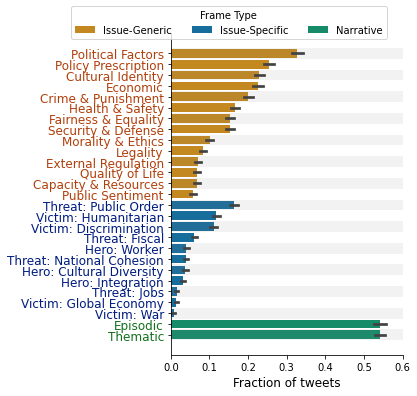

In [101]:
plot_distribution(df_full,frame_labels,'Issue-Generic')
plt.savefig(f'/shared/2/projects/framing/results/plots/annotated_frame_distribution.pdf',bbox_inches='tight')
plt.show()

In [67]:
df = df_full[frame_labels['Narrative']].copy()
df['total'] = df.sum(axis=1)
df['binary'] = [1 if i > 0 else 0 for i in df['total']]
df['binary'].mean()

0.904

In [34]:
def calculate_coverage(df,frame_labels,title):
    coverage_df = pd.DataFrame()
    for frame_type in frame_labels.keys():
        if frame_type != 'Issue-Specific-Combined':
            total = df[frame_labels[frame_type]].sum(axis=1)
            coverage_df[frame_type] = [1 if i > 0 else 0 for i in total]
    sns.barplot(x='variable',y='value',data=pd.melt(coverage_df))
    plt.xlabel('Frame Type')
    plt.ylabel('Coverage')
    return coverage_df.mean()

Issue-General     0.837778
Issue-Specific    0.508889
Narrative         0.846667
dtype: float64

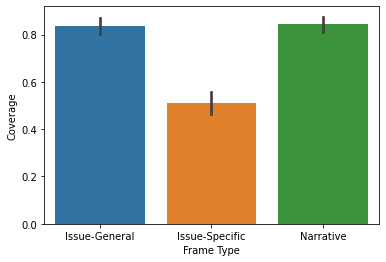

In [35]:
coverage_compare = pd.DataFrame()
calculate_coverage(df_test,frame_labels,'Full Data Set')
#coverage_compare['Train'] = calculate_coverage(df_train,frame_labels,'Train Set')
#coverage_compare['Dev'] = calculate_coverage(df_dev,frame_labels,'Dev Set')
#coverage_compare['Test'] = calculate_coverage(df_test,frame_labels,'Test Set')
#plt.savefig(f'/shared/2/projects/framing/results/plots/annotated_data_coverage.pdf',bbox_inches='tight')


In [93]:
coverage_compare.round(2).transpose()

,Issue-General,Issue-Specific,Narrative
Full,0.84,0.51,0.85
Train,0.88,0.54,0.91
Dev,0.86,0.54,0.89
Test,0.84,0.51,0.85


In [ ]:
p(frame|train) / p(frame)

In [98]:
df_ratio = df_train[frame_labels['Issue-Specific']].mean() / df_full[frame_labels['Issue-Specific']].mean()
sns.barplot(data=df_ratio)

In [102]:
df_ratio = pd.DataFrame(df_ratio).reset_index()
df_ratio.columns=['Frame','Train-to-Full Ratio']
df_ratio

,Frame,Train-to-Full Ratio
0,Hero: Cultural Diversity,1.050296
1,Hero: Integration,1.018836
2,Hero: Worker,0.993056
3,Threat: Fiscal,1.011029
4,Threat: Jobs,0.923913
5,Threat: National Cohesion,1.059322
6,Threat: Public Order,1.036585
7,Victim: Discrimination,0.986446
8,Victim: Global Economy,1.000000
9,Victim: Humanitarian,0.991461


In [124]:
def compare_train_to_eval(df_train,df_eval,frame_labels):
    for frame_type in frame_labels.keys():
        df_ratio = df_train[frame_labels[frame_type]].mean() / df_eval[frame_labels[frame_type]].mean()
        df_ratio = pd.DataFrame(df_ratio).reset_index()
        df_ratio.columns=['Frame','Train-to-Eval Ratio']
        df_ratio = df_ratio.sort_values('Train-to-Eval Ratio',ascending=False)
        sns.barplot(x = 'Train-to-Eval Ratio',y='Frame',data=df_ratio)
        plt.title(frame_type)
        plt.axvline(x=1)
        plt.show()

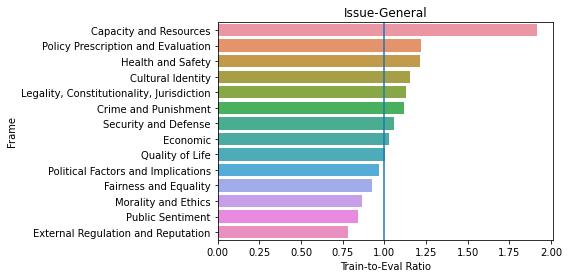

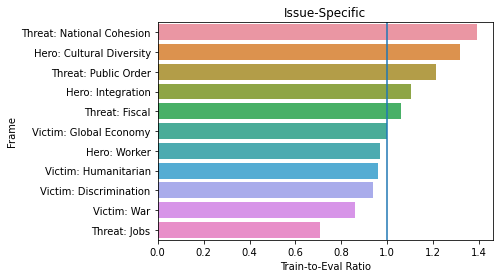

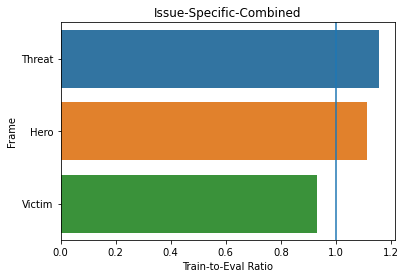

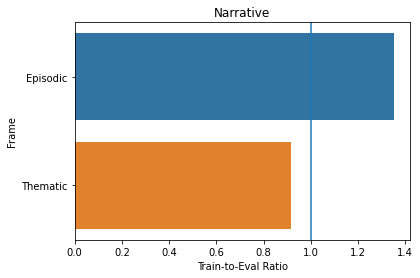

In [125]:
compare_train_to_eval(df_train,pd.concat([df_dev,df_test]),frame_labels)

In [110]:
agreement = pd.read_csv('/home/juliame/framing/labeled_data/eval_interannotator_agreement.tsv',sep='\t',
                       converters={"Coder": ast.literal_eval})

In [111]:
agreement[['coder1', 'coder2']] = pd.DataFrame(agreement['Coder'].tolist(), index=agreement.index)  

In [112]:
agreement = agreement.drop(columns=['Unnamed: 0','Coder'])
agreement['Frame Type'].replace('Issue-General', 'Issue-Generic', inplace=True)


In [113]:
julia_agree = agreement[agreement['coder2']=='julia'].drop(columns=['coder2']).pivot(index='Frame Type', columns='coder1', values='Alpha')
consensus_agree = agreement[agreement['coder2']=='consensus'].drop(columns=['coder2']).pivot(index='Frame Type', columns='coder1', values='Alpha')


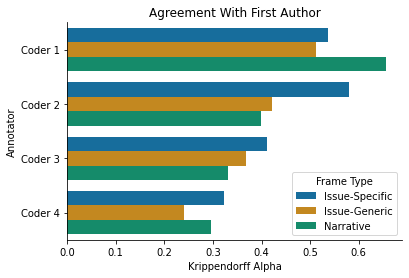

In [118]:
#palette = [sns.color_palette('colorblind')[1],sns.color_palette('colorblind')[0],sns.color_palette('colorblind')[2]]

sns.barplot(y='coder1',x='Alpha',
    data=agreement[agreement['coder2']=='julia'],
    hue = 'Frame Type',palette='colorblind',hue_order=['Issue-Specific','Issue-Generic','Narrative'])
sns.despine()
plt.title('Agreement With First Author')
plt.yticks(range(4),['Coder 1','Coder 2', 'Coder 3','Coder 4'])
plt.ylabel('Annotator')
plt.xlabel('Krippendorff Alpha')
plt.savefig(f'/shared/2/projects/framing/results/plots/agreement_with_julia.pdf',bbox_inches='tight')
plt.show()

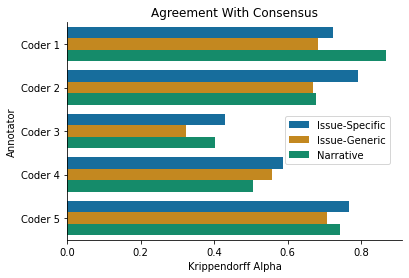

In [121]:
sns.barplot(y='coder1',x='Alpha',
    data=agreement[agreement['coder2']=='consensus'],
    hue = 'Frame Type',palette='colorblind',hue_order=['Issue-Specific','Issue-Generic','Narrative'])
sns.despine()
plt.title('Agreement With Consensus')
plt.yticks(range(5),['Coder 1','Coder 2','Coder 3','Coder 4','Coder 5'])
plt.ylabel('Annotator')
plt.xlabel('Krippendorff Alpha')
plt.legend(loc=(.65,.35))
plt.savefig(f'/shared/2/projects/framing/results/plots/agreement_with_consensus.pdf',bbox_inches='tight')
plt.show()

In [8]:
df = agreement[agreement['coder2']=='julia']

In [9]:
df[df['coder1']=='ceren'] * 

,Frame Type,Alpha,coder1,coder2
0,Issue-General,0.512380,ceren,julia
1,Issue-Specific,0.536747,ceren,julia
2,Narrative,0.656131,ceren,julia
3,Issue-General,0.421172,david,julia
4,Issue-Specific,0.579789,david,julia
5,Narrative,0.398037,david,julia
6,Issue-General,0.367879,anoop,julia
7,Issue-Specific,0.411990,anoop,julia
8,Narrative,0.330780,anoop,julia
9,Issue-General,0.241141,shiqi,julia


In [11]:
300+75+270+255

900

In [12]:
coder_count = {}
coder_count['ceren'] = 270
coder_count['anoop'] = 300
coder_count['david'] = 255
coder_count['shiqi'] = 75

In [13]:
df['Num'] = [coder_count[c] for c in df['coder1']]

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df['product'] = df['Alpha'] * df['Num']

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df

,Frame Type,Alpha,coder1,coder2,Num,product
0,Issue-General,0.512380,ceren,julia,270,138.342651
1,Issue-Specific,0.536747,ceren,julia,270,144.921776
2,Narrative,0.656131,ceren,julia,270,177.155408
3,Issue-General,0.421172,david,julia,255,107.398974
4,Issue-Specific,0.579789,david,julia,255,147.846088
5,Narrative,0.398037,david,julia,255,101.499527
6,Issue-General,0.367879,anoop,julia,300,110.363690
7,Issue-Specific,0.411990,anoop,julia,300,123.596914
8,Narrative,0.330780,anoop,julia,300,99.234072
9,Issue-General,0.241141,shiqi,julia,75,18.085581


In [22]:
sum(df['product'])/sum(df['Num'])

0.44989807682610256

In [23]:
df['Alpha'].mean()

0.42275961558647507

In [24]:
df1 = df[df['Frame Type']=='Issue-General']
sum(df1['product'])/sum(df1['Num'])

0.4157676625217645

In [25]:
df1 = df[df['Frame Type']=='Issue-Specific']
sum(df1['product'])/sum(df1['Num'])

0.4894342177139338

In [26]:
df1 = df[df['Frame Type']=='Narrative']
sum(df1['product'])/sum(df1['Num'])

0.4444923502426092